## POTATO DISEASES

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed =123,
    shuffle = True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
    

Found 2145 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[0 1 0 1 1 0 2 1 1 2 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 2 1 1 1 2 0]


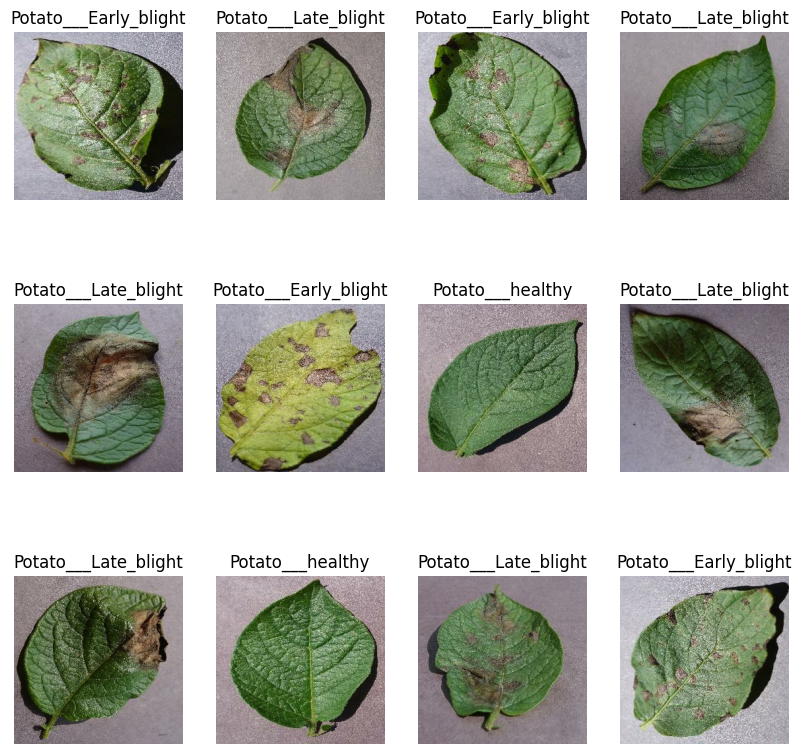

In [5]:
plt.figure(figsize=(10,10))
for image_batch, lables_batch in dataset.take(1):
    print(image_batch.shape)
    print(lables_batch.numpy())
    for i in range(12):
        ax =plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[lables_batch[i]])
        plt.axis("off")
    
    

In [6]:
# 80% ==> Training
# 20% ==> Test
#     10% ==> Validation
#     10% ==> Test

In [7]:
len(dataset)

68

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [10]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [11]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [21]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

d:\GLA_GenAI\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.4779 - loss: 0.9422 - val_accuracy: 0.4531 - val_loss: 0.8772
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.5505 - loss: 0.8301 - val_accuracy: 0.8177 - val_loss: 0.5574
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.7702 - loss: 0.5934 - val_accuracy: 0.8750 - val_loss: 0.3807
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1061s 20s/step - accuracy: 0.8298 - loss: 0.4263 - val_accuracy: 0.8438 - val_loss: 0.4008
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.8534 - loss: 0.3750 - val_accuracy: 0.9010 - val_loss: 0.2588
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 196s 4s/step - accuracy: 0.8584 - loss: 0.3338 - val_accuracy: 0.9271 - val_loss: 0.2194
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 8596s 162s/step - accuracy: 0.9055 - loss: 0.2445 - val_accuracy: 0.9271 - val_loss: 0.2241
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 368s 7s/step - accuracy: 0.8973 - loss: 0.2567 - val_accuracy: 0.901

In [26]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 720ms/step - accuracy: 0.9322 - loss: 0.1928


In [27]:
scores

[0.1344130039215088, 0.95703125]

In [28]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [30]:
len(history.history['loss'])

20

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

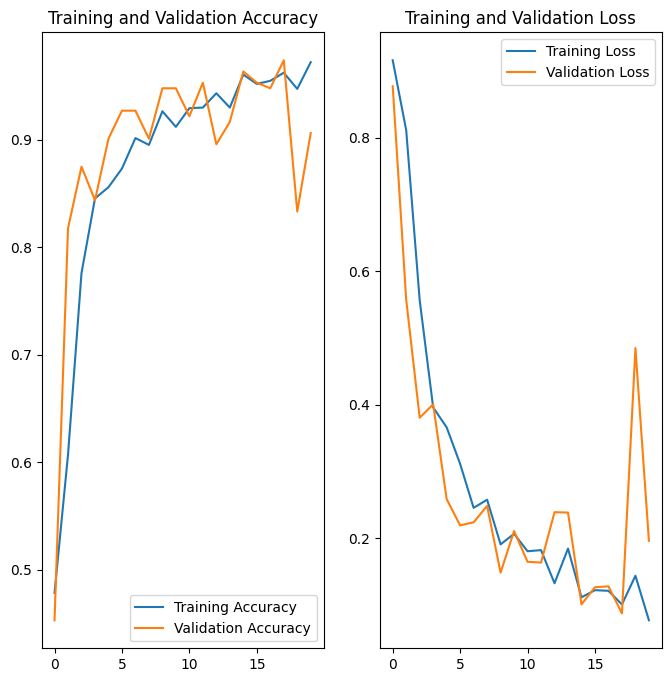

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
predicted label: Potato___Early_blight


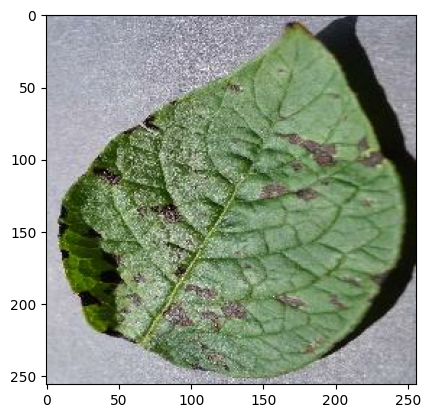

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


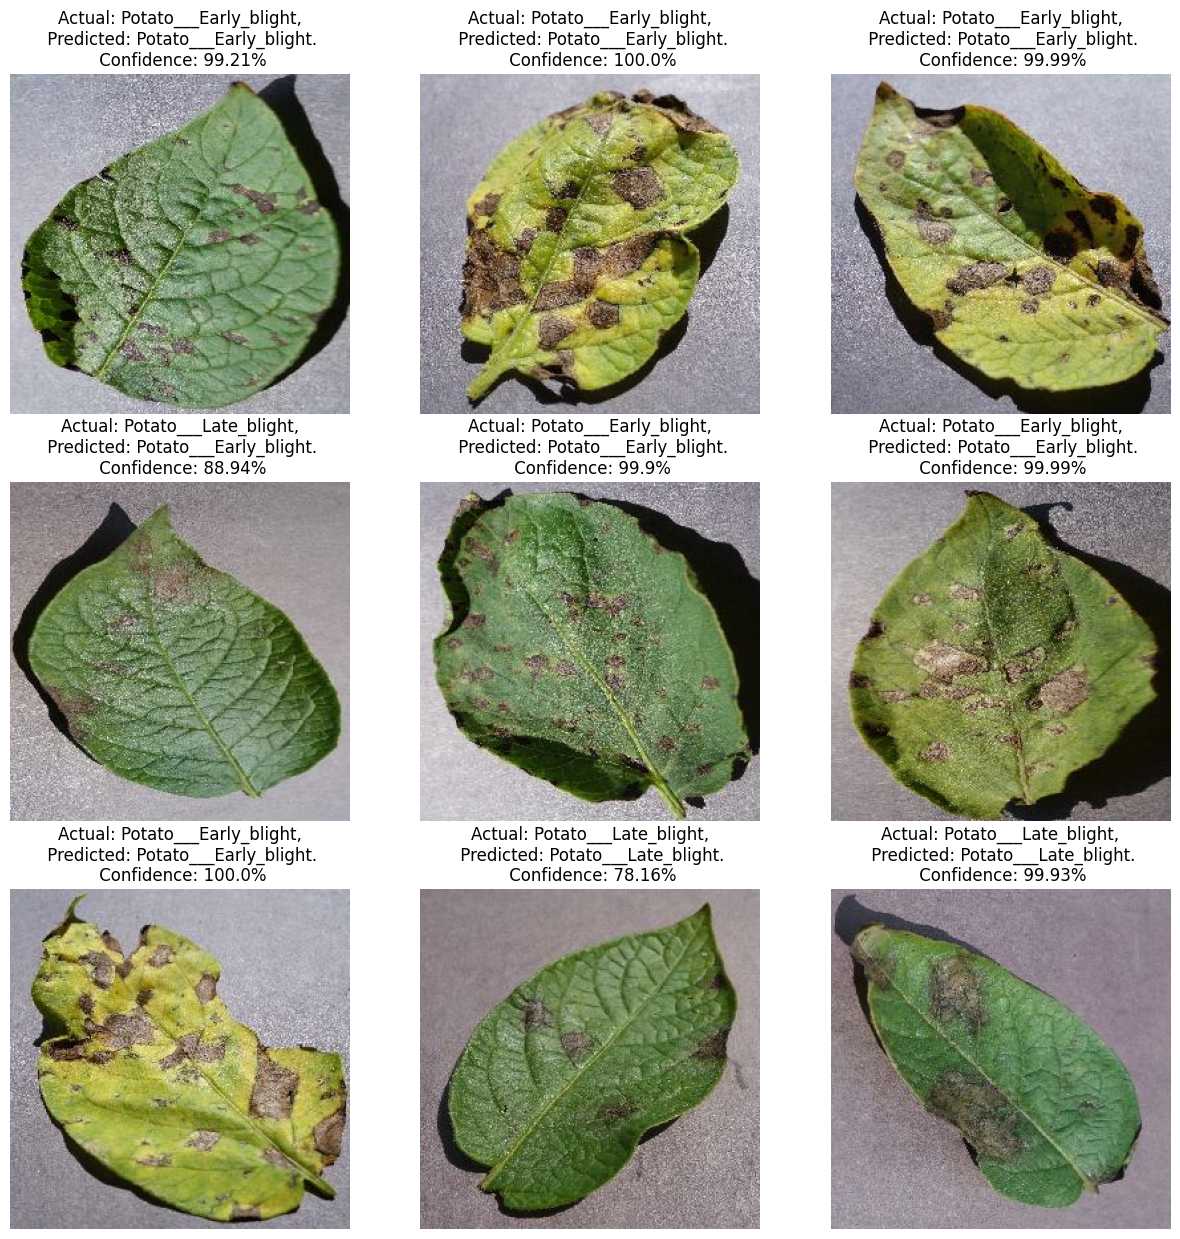

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [42]:
# import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"../models/{model_version}")

In [41]:
# model.save('my_model.keras')
model.save(f"../saved_models/my_model.keras")